<a href="https://colab.research.google.com/github/data-science-and-machine-learning/amazon-fine-food-reviews-K-means/blob/master/Amazon_Fine_Food_Reviews_Analysis_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
!unzip drive/My\ Drive/amazon-fine-food-reviews.zip -d amazon_fine_food_reviews_data

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
Archive:  drive/My Drive/amazon-fine-food-reviews.zip
  inflating: amazon_fine_food_reviews_data/Reviews.csv  
  inflating: amazon_fine_food_reviews_data/database.sqlite  
  inflating: amazon_fine_food_reviews_data/hashes.txt  


In [56]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
!pip install kneed

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

from tqdm import tqdm_notebook as tqdm
import os

In [57]:
# using SQLite Table to read data.
con = sqlite3.connect('amazon_fine_food_reviews_data/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...

[3 rows x 10 columns]

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [59]:
print(display.shape)
display.head()

(80668, 7)


UserId  ... COUNT(*)
0  #oc-R115TNMSPFT9I7  ...        2
1  #oc-R11D9D7SHXIJB9  ...        3
2  #oc-R11DNU2NBKQ23Z  ...        2
3  #oc-R11O5J5ZVQE25C  ...        3
4  #oc-R12KPBODL2B5ZD  ...        2

[5 rows x 7 columns]

In [60]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId  ... COUNT(*)
80638  AZY10LLTJ71NX  ...        5

[1 rows x 7 columns]

In [61]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [62]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id  ...                                               Text
0   78445  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1  138317  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2  138277  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3   73791  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4  155049  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

[5 rows x 10 columns]

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [64]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [65]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [66]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id  ...                                               Text
0  64422  ...  My son loves spaghetti so I didn't hesitate or...
1  44737  ...  It was almost a 'love at first bite' - the per...

[2 rows x 10 columns]

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [68]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [69]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [70]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [71]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [73]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [74]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [75]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [77]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:21<00:00, 2183.33it/s]


In [78]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [80]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 39364)
the number of unique words  39364


## [4.2] Bi-Grams and n-Grams.

In [81]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [82]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able feed', 'able figure', 'able find']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (46071, 27311)
the number of unique words including both unigrams and bigrams  27311


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [84]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8209223747253418), ('good', 0.8101738691329956), ('awesome', 0.8078150153160095), ('terrific', 0.8063924312591553), ('excellent', 0.8034632205963135), ('wonderful', 0.7862707376480103), ('amazing', 0.771693229675293), ('perfect', 0.7666193842887878), ('decent', 0.7221663594245911), ('ideal', 0.6659470796585083)]
[('nastiest', 0.7334078550338745), ('best', 0.7217287421226501), ('experienced', 0.6830388903617859), ('awful', 0.6577200889587402), ('greatest', 0.6494109034538269), ('horrible', 0.6454295516014099), ('hottest', 0.6377099752426147), ('tastiest', 0.6337148547172546), ('ive', 0.6332641243934631), ('closest', 0.6255066990852356)]


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [85]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
          pass
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 46071/46071 [00:08<00:00, 5668.23it/s]

46071
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [87]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
          pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 46071/46071 [00:19<00:00, 2324.15it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>


total elapsed time:  8212.480854511261


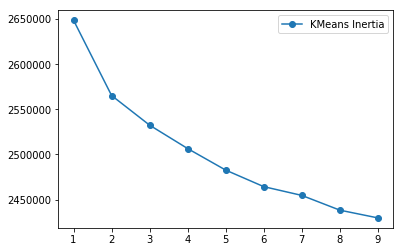

In [88]:
# Please write all the code with proper documentation
# Using bigrams

from sklearn.cluster import KMeans
import time
from tqdm import tqdm_notebook as tqdm

t0 = time.time()
score=[]
ks=list(range(1,10))
for k in tqdm(ks):
    kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
    kmeans.fit(final_bigram_counts)
    score.append(kmeans.inertia_)

print('total elapsed time: ', time.time()- t0)
plt.plot(ks, score, '-o', label='KMeans Inertia')
plt.legend()
plt.show()


### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [89]:
# Word cloud for the per each cluster:
est = KMeans(n_clusters = 2)
est.fit(final_bigram_counts)
pred = est.predict(final_bigram_counts)
labels = est.labels_
print(np.shape(labels))

(46071,)


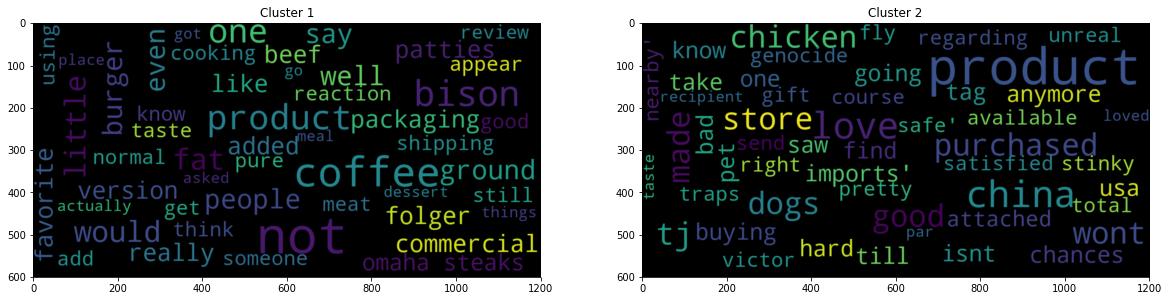

In [90]:
wcdf = pd.DataFrame([preprocessed_reviews, labels]).T

corp= wcdf[wcdf[1]==0][0].values
wordcloud1 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==1][0].values
wordcloud2 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax1.imshow(wordcloud1, interpolation = 'bilinear')
ax1.set(title= 'Cluster 1')
ax2 = fig.add_subplot(122)
ax2.imshow(wordcloud2, interpolation = 'bilinear')
ax2.set(title= 'Cluster 2')
plt.show()

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>


total elapsed time:  13621.161170244217


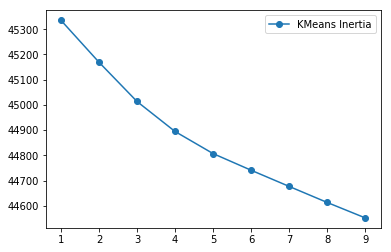

In [91]:
from sklearn.cluster import KMeans
import time
from tqdm import tqdm_notebook as tqdm

t0 = time.time()
score=[]
ks=list(range(1,10))
for k in tqdm(ks):
    kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
    kmeans.fit(final_tf_idf)
    score.append(kmeans.inertia_)

print('total elapsed time: ', time.time()- t0)
plt.plot(ks, score, '-o', label='KMeans Inertia')
plt.legend()
plt.show()




### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

In [92]:
# Word cloud for the per each cluster:
# 3 seems like the knee point
est = KMeans(n_clusters = 3)
est.fit(final_tf_idf)
pred = est.predict(final_tf_idf)
labels = est.labels_
print(np.shape(labels))

(46071,)


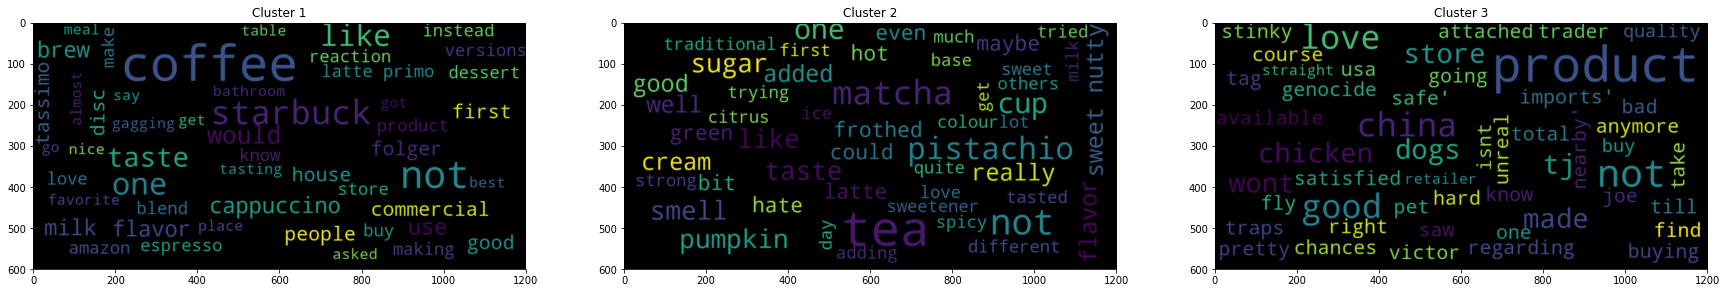

In [93]:
wcdf = pd.DataFrame([preprocessed_reviews, labels]).T

corp= wcdf[wcdf[1]==0][0].values
wordcloud1 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==1][0].values
wordcloud2 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==2][0].values
wordcloud3 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))


fig = plt.figure(figsize=(30,30))
ax1 = fig.add_subplot(131)
ax1.imshow(wordcloud1, interpolation = 'bilinear')
ax1.set(title= 'Cluster 1')
ax2 = fig.add_subplot(132)
ax2.imshow(wordcloud2, interpolation = 'bilinear')
ax2.set(title= 'Cluster 2')
ax3 = fig.add_subplot(133)
ax3.imshow(wordcloud3, interpolation = 'bilinear')
ax3.set(title= 'Cluster 3')
plt.show()

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>


total elapsed time:  36.455214738845825


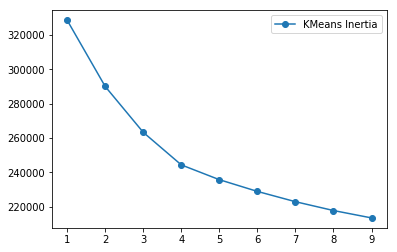

In [94]:
from sklearn.cluster import KMeans
import time
from tqdm import tqdm_notebook as tqdm

t0 = time.time()
score=[]
ks=list(range(1,10))
for k in tqdm(ks):
  kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
  kmeans.fit(sent_vectors)
  score.append(kmeans.inertia_)

print('total elapsed time: ', time.time()- t0)
plt.plot(ks, score, '-o', label='KMeans Inertia')
plt.legend()
plt.show()


### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

In [95]:
# Please write all the code with proper documentation
# Word cloud for the per each cluster:
est = KMeans(n_clusters = 2)
est.fit(sent_vectors)
pred = est.predict(sent_vectors)
labels = est.labels_
print(np.shape(labels))


(46071,)


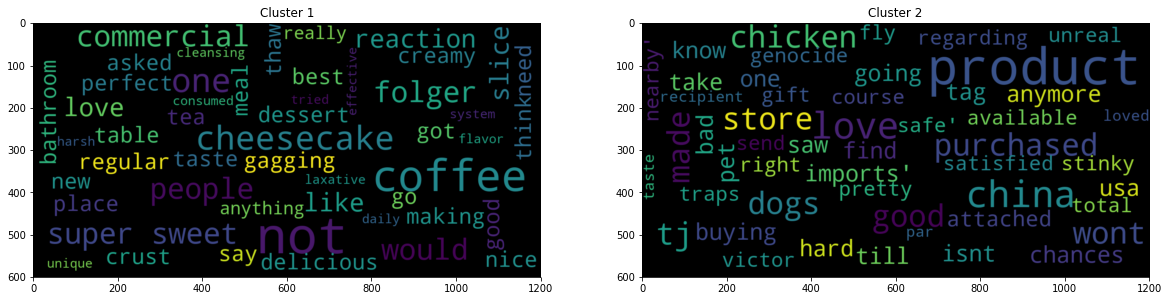

In [96]:
wcdf = pd.DataFrame([preprocessed_reviews, labels]).T

corp= wcdf[wcdf[1]==0][0].values
wordcloud1 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==1][0].values
wordcloud2 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax1.imshow(wordcloud1, interpolation = 'bilinear')
ax1.set(title= 'Cluster 1')
ax2 = fig.add_subplot(122)
ax2.imshow(wordcloud2, interpolation = 'bilinear')
ax2.set(title= 'Cluster 2')
plt.show()

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>


total elapsed time:  31.048308849334717


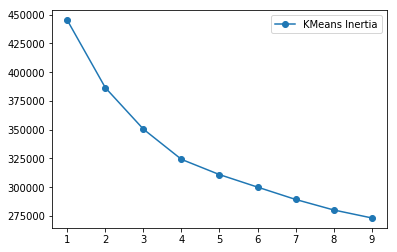

In [97]:
from sklearn.cluster import KMeans
import time
from tqdm import tqdm_notebook as tqdm

t0 = time.time()
score=[]
ks=list(range(1,10))
for k in tqdm(ks):
    kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1)
    kmeans.fit(tfidf_sent_vectors)
    score.append(kmeans.inertia_)

print('total elapsed time: ', time.time()- t0)
plt.plot(ks, score, '-o', label='KMeans Inertia')
plt.legend()
plt.show()


### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

In [98]:
# Please write all the code with proper documentation
# Word cloud for the per each cluster:
est = KMeans(n_clusters = 2)
est.fit(tfidf_sent_vectors)
pred = est.predict(tfidf_sent_vectors)
labels = est.labels_
print(np.shape(labels))


(46071,)


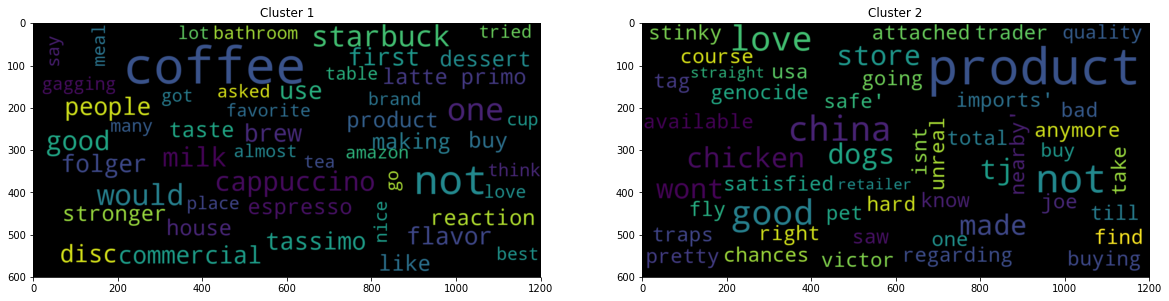

In [99]:
wcdf = pd.DataFrame([preprocessed_reviews, labels]).T

corp= wcdf[wcdf[1]==0][0].values
wordcloud1 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==1][0].values
wordcloud2 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax1.imshow(wordcloud1, interpolation = 'bilinear')
ax1.set(title= 'Cluster 1')
ax2 = fig.add_subplot(122)
ax2.imshow(wordcloud2, interpolation = 'bilinear')
ax2.set(title= 'Cluster 2')
plt.show()

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [0]:
from sklearn.cluster import AgglomerativeClustering
import time
from tqdm import tqdm_notebook as tqdm
from random import sample 


In [101]:
# Please write all the code with proper documentation
# Word cloud for the per each cluster:
#n_cluster= 2

labels=[]
clusters= [2, 3, 4, 5]
for c in tqdm(clusters):
  est = AgglomerativeClustering(n_clusters = c)
  est.fit(sent_vectors[:10000])
  labels.append(est.labels_)


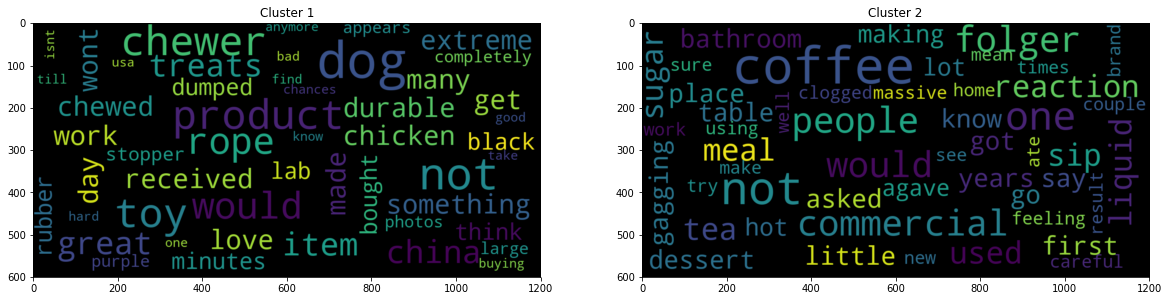

In [102]:
wcdf = pd.DataFrame([preprocessed_reviews, labels[0]]).T

corp= wcdf[wcdf[1]==0][0].values
wordcloud1 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==1][0].values
wordcloud2 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax1.imshow(wordcloud1, interpolation = 'bilinear')
ax1.set(title= 'Cluster 1')
ax2 = fig.add_subplot(122)
ax2.imshow(wordcloud2, interpolation = 'bilinear')
ax2.set(title= 'Cluster 2')
plt.show()

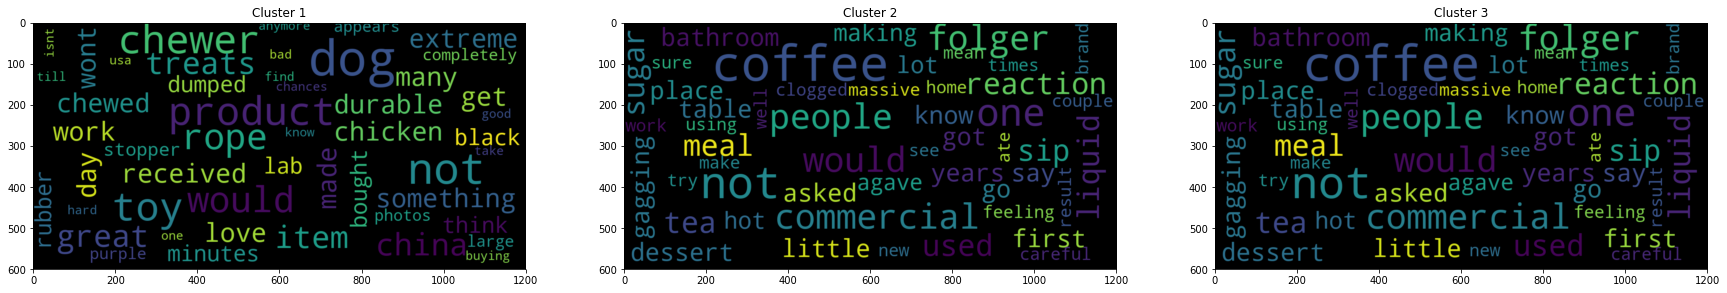

In [103]:
wcdf = pd.DataFrame([preprocessed_reviews, labels[1]]).T

corp= wcdf[wcdf[1]==0][0].values
wordcloud1 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==1][0].values
wordcloud2 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==2][0].values
wordcloud3 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))

fig = plt.figure(figsize=(30,30))
ax1 = fig.add_subplot(131)
ax1.imshow(wordcloud1, interpolation = 'bilinear')
ax1.set(title= 'Cluster 1')
ax2 = fig.add_subplot(132)
ax2.imshow(wordcloud2, interpolation = 'bilinear')
ax2.set(title= 'Cluster 2')
ax2 = fig.add_subplot(133)
ax2.imshow(wordcloud2, interpolation = 'bilinear')
ax2.set(title= 'Cluster 3')
plt.show()

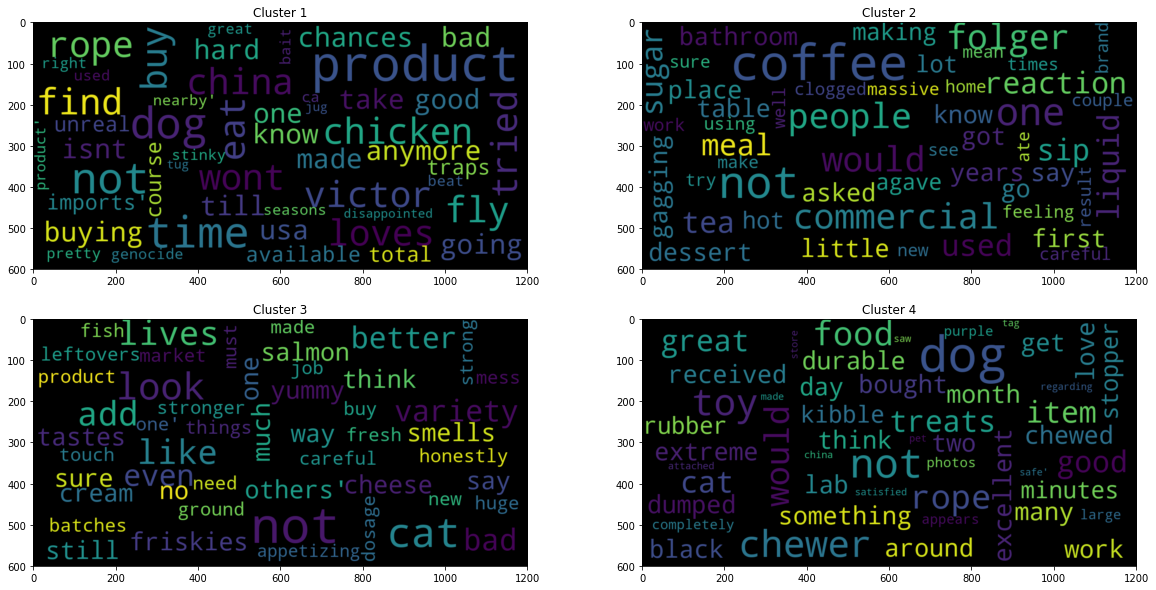

In [104]:
wcdf = pd.DataFrame([preprocessed_reviews, labels[2]]).T

corp= wcdf[wcdf[1]==0][0].values
wordcloud1 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==1][0].values
wordcloud2 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==2][0].values
wordcloud3 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==3][0].values
wordcloud4 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(221)
ax1.imshow(wordcloud1, interpolation = 'bilinear')
ax1.set(title= 'Cluster 1')
ax2 = fig.add_subplot(222)
ax2.imshow(wordcloud2, interpolation = 'bilinear')
ax2.set(title= 'Cluster 2')
ax3 = fig.add_subplot(223)
ax3.imshow(wordcloud3, interpolation = 'bilinear')
ax3.set(title= 'Cluster 3')
ax4 = fig.add_subplot(224)
ax4.imshow(wordcloud4, interpolation = 'bilinear')
ax4.set(title= 'Cluster 4')
plt.show()

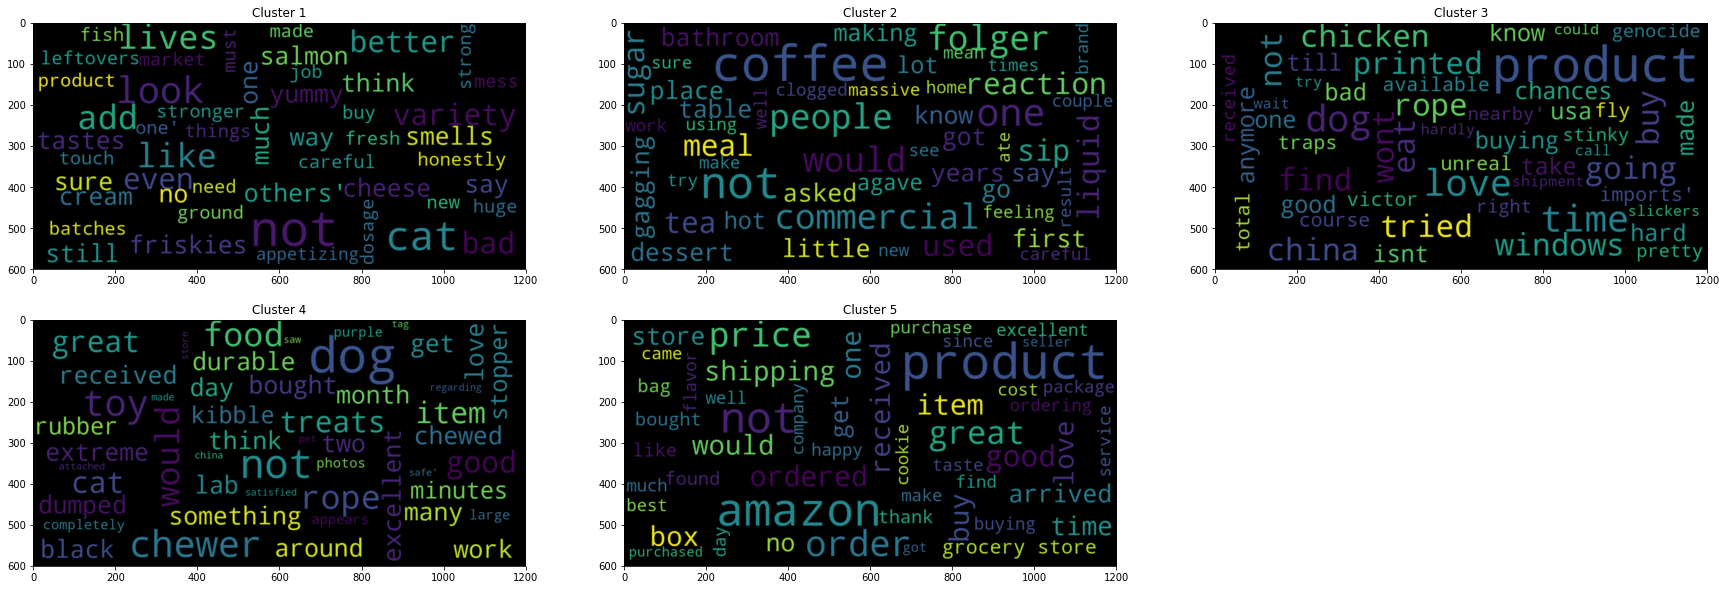

In [105]:
wcdf = pd.DataFrame([preprocessed_reviews, labels[3]]).T

corp= wcdf[wcdf[1]==0][0].values
wordcloud1 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==1][0].values
wordcloud2 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==2][0].values
wordcloud3 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==3][0].values
wordcloud4 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==4][0].values
wordcloud5 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))

fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(231)
ax1.imshow(wordcloud1, interpolation = 'bilinear')
ax1.set(title= 'Cluster 1')
ax2 = fig.add_subplot(232)
ax2.imshow(wordcloud2, interpolation = 'bilinear')
ax2.set(title= 'Cluster 2')
ax3 = fig.add_subplot(233)
ax3.imshow(wordcloud3, interpolation = 'bilinear')
ax3.set(title= 'Cluster 3')
ax4 = fig.add_subplot(234)
ax4.imshow(wordcloud4, interpolation = 'bilinear')
ax4.set(title= 'Cluster 4')
ax5 = fig.add_subplot(235)
ax5.imshow(wordcloud5, interpolation = 'bilinear')
ax5.set(title= 'Cluster 5')
plt.show()

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [106]:
# Please write all the code with proper documentation
# Word cloud for the per each cluster:
#n_cluster= 2

labels=[]
clusters= [2, 3, 4, 5]
for c in tqdm(clusters):
  est = AgglomerativeClustering(n_clusters = c)
  est.fit(tfidf_sent_vectors[:10000])
  labels.append(est.labels_)


### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

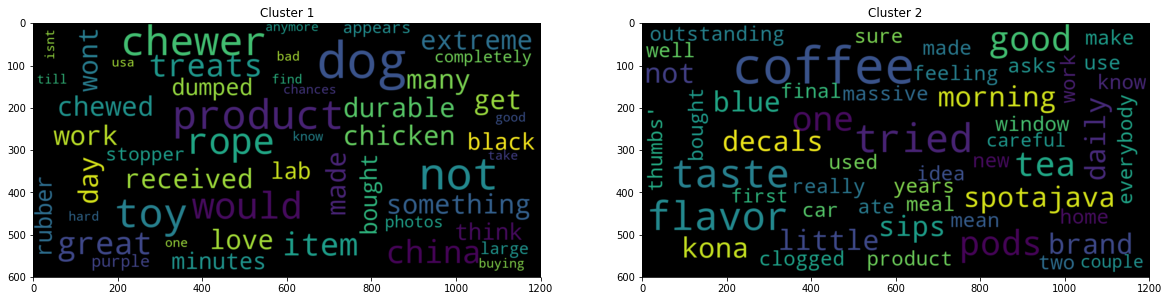

In [107]:
wcdf = pd.DataFrame([preprocessed_reviews, labels[0]]).T

corp= wcdf[wcdf[1]==0][0].values
wordcloud1 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==1][0].values
wordcloud2 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax1.imshow(wordcloud1, interpolation = 'bilinear')
ax1.set(title= 'Cluster 1')
ax2 = fig.add_subplot(122)
ax2.imshow(wordcloud2, interpolation = 'bilinear')
ax2.set(title= 'Cluster 2')
plt.show()

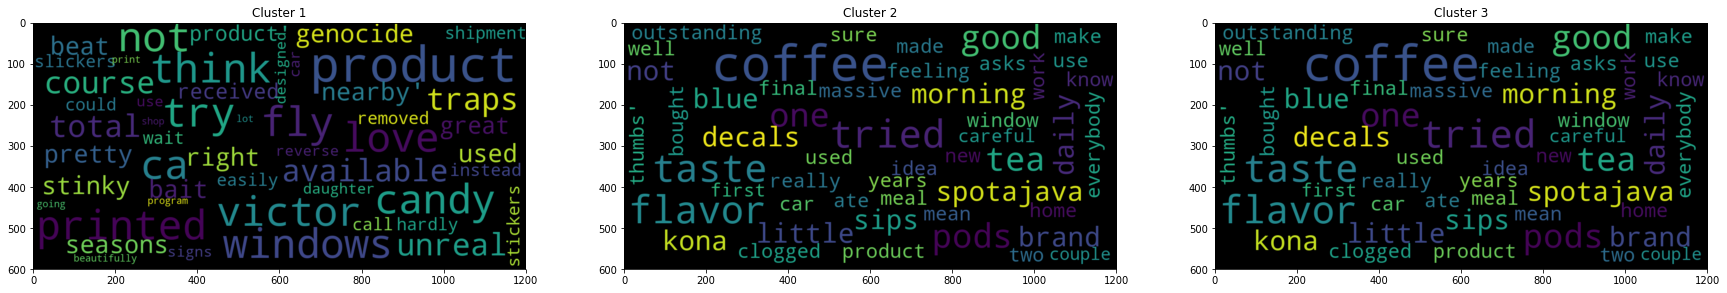

In [108]:
wcdf = pd.DataFrame([preprocessed_reviews, labels[1]]).T

corp= wcdf[wcdf[1]==0][0].values
wordcloud1 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==1][0].values
wordcloud2 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==2][0].values
wordcloud3 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))

fig = plt.figure(figsize=(30,30))
ax1 = fig.add_subplot(131)
ax1.imshow(wordcloud1, interpolation = 'bilinear')
ax1.set(title= 'Cluster 1')
ax2 = fig.add_subplot(132)
ax2.imshow(wordcloud2, interpolation = 'bilinear')
ax2.set(title= 'Cluster 2')
ax2 = fig.add_subplot(133)
ax2.imshow(wordcloud2, interpolation = 'bilinear')
ax2.set(title= 'Cluster 3')
plt.show()

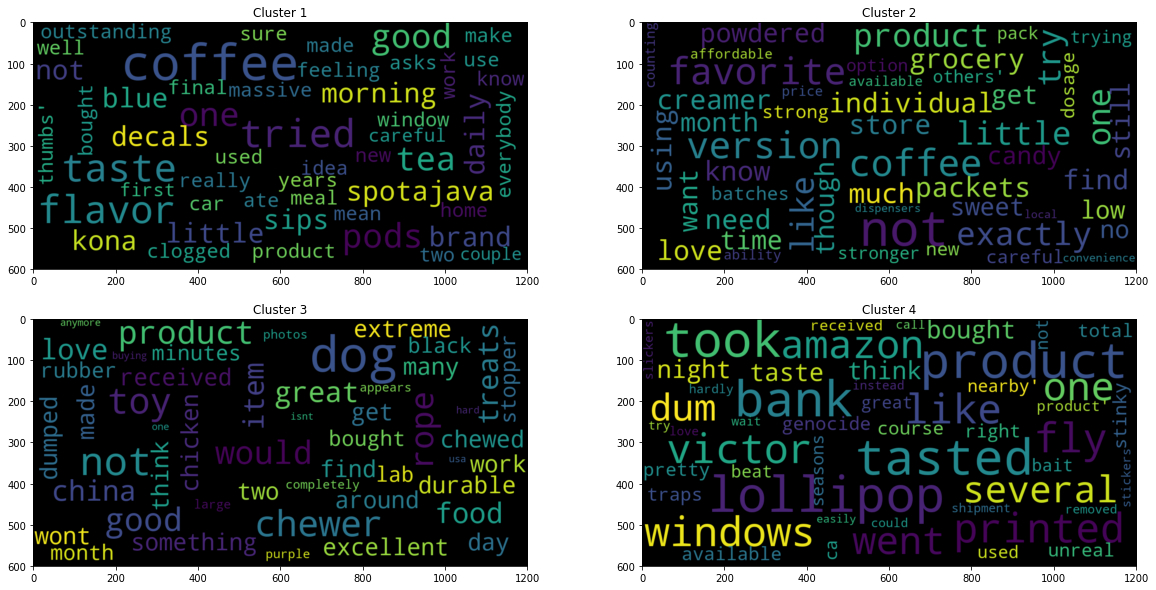

In [109]:
wcdf = pd.DataFrame([preprocessed_reviews, labels[2]]).T

corp= wcdf[wcdf[1]==0][0].values
wordcloud1 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==1][0].values
wordcloud2 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==2][0].values
wordcloud3 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==3][0].values
wordcloud4 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(221)
ax1.imshow(wordcloud1, interpolation = 'bilinear')
ax1.set(title= 'Cluster 1')
ax2 = fig.add_subplot(222)
ax2.imshow(wordcloud2, interpolation = 'bilinear')
ax2.set(title= 'Cluster 2')
ax3 = fig.add_subplot(223)
ax3.imshow(wordcloud3, interpolation = 'bilinear')
ax3.set(title= 'Cluster 3')
ax4 = fig.add_subplot(224)
ax4.imshow(wordcloud4, interpolation = 'bilinear')
ax4.set(title= 'Cluster 4')
plt.show()

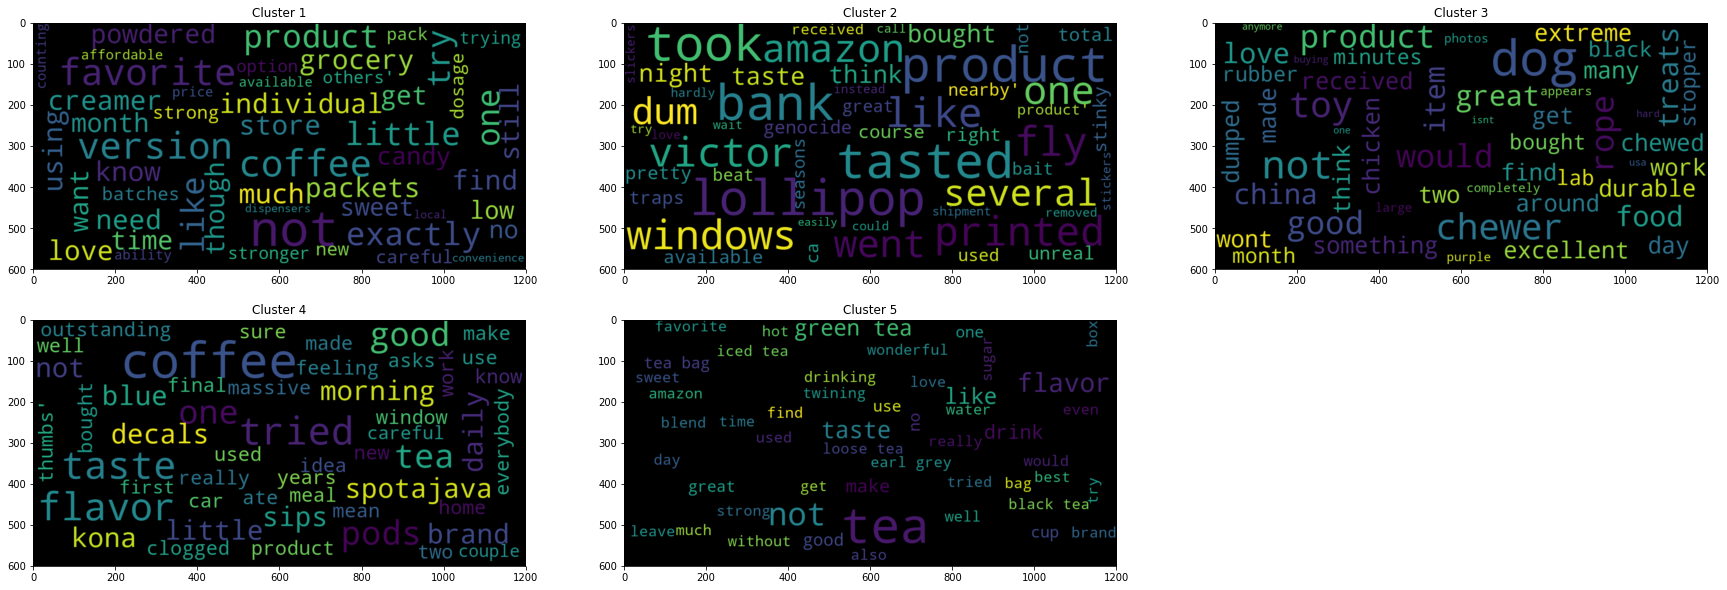

In [110]:
wcdf = pd.DataFrame([preprocessed_reviews, labels[3]]).T

corp= wcdf[wcdf[1]==0][0].values
wordcloud1 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==1][0].values
wordcloud2 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==2][0].values
wordcloud3 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==3][0].values
wordcloud4 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==4][0].values
wordcloud5 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))

fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(231)
ax1.imshow(wordcloud1, interpolation = 'bilinear')
ax1.set(title= 'Cluster 1')
ax2 = fig.add_subplot(232)
ax2.imshow(wordcloud2, interpolation = 'bilinear')
ax2.set(title= 'Cluster 2')
ax3 = fig.add_subplot(233)
ax3.imshow(wordcloud3, interpolation = 'bilinear')
ax3.set(title= 'Cluster 3')
ax4 = fig.add_subplot(234)
ax4.imshow(wordcloud4, interpolation = 'bilinear')
ax4.set(title= 'Cluster 4')
ax5 = fig.add_subplot(235)
ax5.imshow(wordcloud5, interpolation = 'bilinear')
ax5.set(title= 'Cluster 5')
plt.show()

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

46071
(2, 46071, 50) <class 'tuple'>


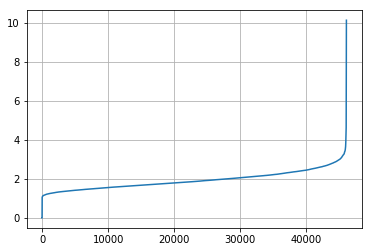

In [111]:
from sklearn.neighbors import NearestNeighbors as NN
from sklearn.cluster import DBSCAN
#minpt should be greater than dimentions
#for w2v dim = 50
print(len(sent_vectors))
minpt = 50
distance = {}
est= NN(n_neighbors= minpt, metric= "euclidean")
est.fit(sent_vectors)
#query distances
dist = est.kneighbors(n_neighbors= minpt, return_distance= True)
print(np.shape(dist), type(dist))

for d, i in zip(dist[0], dist[1]):
  # Distance and id of the farthest neighbor
  distance[i[-1]]= d[-1]

#print(distance)
sorted_distance = sorted((val,key) for (key, val) in distance.items())
distances = []
indeces = []

for d, i in sorted_distance:
    distances.append(d)
    indeces.append(i)

plt.plot(sorted(indeces), distances)
plt.grid(which='major', alpha=1)
plt.show()



In [113]:
# take eps value at knee point .30
est= DBSCAN(eps= 3, min_samples= minpt)
est.fit(sent_vectors)

labels = est.labels_
print(pd.Series(labels).value_counts())

 0    45987
-1       84
dtype: int64


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

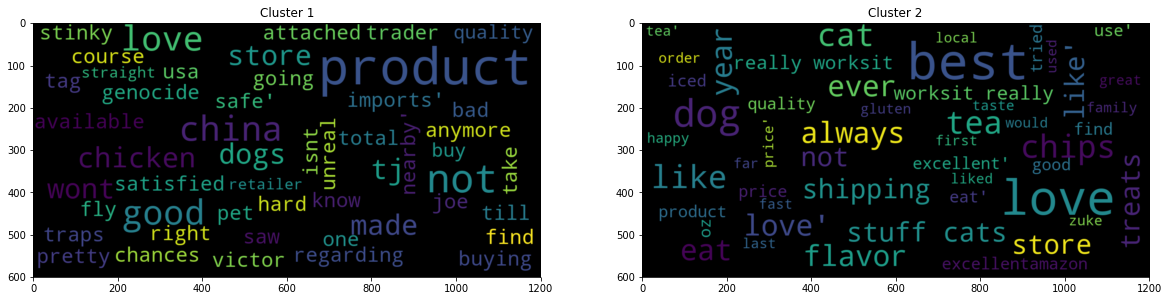

In [114]:
# Please write all the code with proper documentation

labels = est.labels_
wcdf = pd.DataFrame([preprocessed_reviews, labels]).T

corp= wcdf[wcdf[1]==0][0].values
wordcloud1 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==-1][0].values
wordcloud2 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax1.imshow(wordcloud1, interpolation = 'bilinear')
ax1.set(title= 'Cluster 1')
ax2 = fig.add_subplot(122)
ax2.imshow(wordcloud2, interpolation = 'bilinear')
ax2.set(title= 'Cluster 2')
plt.show()

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

(2, 46071, 50) <class 'tuple'>


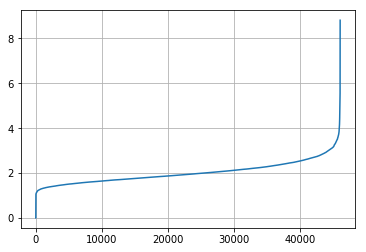

In [115]:
# Please write all the code with proper documentation
from sklearn.neighbors import NearestNeighbors as NN
from sklearn.cluster import DBSCAN
#minpt should be greater than dimentions
#for w2v dim = 50
minpt = 50
distance = {}
est= NN(n_neighbors= minpt, metric= "euclidean")
est.fit(tfidf_sent_vectors)
#query distances
dist = est.kneighbors(n_neighbors= minpt, return_distance= True)
print(np.shape(dist), type(dist))

for d, i in zip(dist[0], dist[1]):
  # Distance and id of the farthest neighbor
  distance[i[-1]]= d[-1]

#print(distance)
sorted_distance = sorted((val,key) for (key, val) in distance.items())
distances = []
indeces = []

for d, i in sorted_distance:
    distances.append(d)
    indeces.append(i)

plt.plot(sorted(indeces), distances)
plt.grid(which='major', alpha=1)
plt.show()



### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

 0    45987
-1       84
dtype: int64


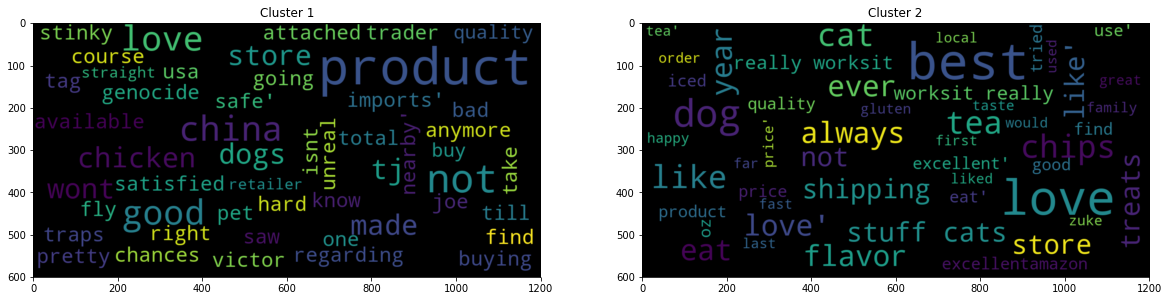

In [116]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# take eps value at knee point .30

est= DBSCAN(eps= 3, min_samples= minpt)
est.fit(sent_vectors)

labels = est.labels_
print(pd.Series(labels).value_counts())
wcdf = pd.DataFrame([preprocessed_reviews, labels]).T

corp= wcdf[wcdf[1]==0][0].values
wordcloud1 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))
corp= wcdf[wcdf[1]==-1][0].values
wordcloud2 = WordCloud(stopwords=stopwords, max_words=50, max_font_size=40, scale=3, random_state=1).generate(str(corp))

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(121)
ax1.imshow(wordcloud1, interpolation = 'bilinear')
ax1.set(title= 'Cluster 1')
ax2 = fig.add_subplot(122)
ax2.imshow(wordcloud2, interpolation = 'bilinear')
ax2.set(title= 'Cluster 2')
plt.show()

# [6] Conclusions

In [121]:
# Please compare all your models using Prettytable library. 
# You can have 3 tables, one each for kmeans, agllomerative and dbscan

from prettytable import PrettyTable
table1= PrettyTable(['KMeans'])
table1.add_row(["1. KMeans clustering is a centeroid based clustering technique"])
table1.add_row(["2. KMeans takes care of the distance between datapoints can be tuned by number of clusters"])
table1.add_row(["3. KMeans clustering provides inertia as an attribute, which can be used as a scoring parameter for elbow method"])
table1.add_row(["4. We can plot the inertia which is the intercluster distance and visualise the elbow point to find the best number of cluster"])


table2= PrettyTable(['AgglomerativeClustering'])
table2.add_row(['1. Agglomerative clustering is a heirarchical based clustering technique'])
table2.add_row(['2. Various types of distance metrix like euclidian, cosine, manhattan can be used with this method wherein domain knowledge comes in handy'])
table2.add_row(['3. Aggleromative clusetering performs clustering in heirarchy and keep clustering unless number of clusters is achieved'])

table3= PrettyTable(['DBSCAN'])
table3.add_row(['1. DBSCAN clustering is a density based clustering technique'])
table3.add_row(['2. epsilion is used as a hyperparameter, which is determined using knee of index vs distance plot'])

table1.align= 'l'
table2.align= 'l'
table3.align= 'l'

print(table1)
print(table2)
print(table3)


table4= PrettyTable(['Estimator', 'Knee/elbow Hyper parameter'])
table4.add_row(['KMeans', 'n_clusters = 2'])
table4.add_row(['Agglomerative', 'n_clusters = 2'])
table4.add_row(['DBSCAN', 'eps= 3'])
table4.align= 'l'

print(table4)

+--------------------------------------------------------------------------------------------------------------------------------+
| KMeans                                                                                                                         |
+--------------------------------------------------------------------------------------------------------------------------------+
| 1. KMeans clustering is a centeroid based clustering technique                                                                 |
| 2. KMeans takes care of the distance between datapoints can be tuned by number of clusters                                     |
| 3. KMeans clustering provides inertia as an attribute, which can be used as a scoring parameter for elbow method               |
| 4. We can plot the inertia which is the intercluster distance and visualise the elbow point to find the best number of cluster |
+----------------------------------------------------------------------------------